In [210]:
# Cell 01: Imports, paths, device

import os, math, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

# Kaggle input paths
DATA_ROOT = "/kaggle/input/smart-meters-in-london"
METER_PATH = os.path.join(DATA_ROOT, "daily_dataset.csv")
HH_PATH    = os.path.join(DATA_ROOT, "informations_households.csv")
WEA_PATH   = os.path.join(DATA_ROOT, "weather_hourly_darksky.csv")

print("DATA_ROOT =", DATA_ROOT)
print("METER_CSV =", os.path.exists(METER_PATH), METER_PATH)
print("HOUSEHOLD_INFO_CSV =", os.path.exists(HH_PATH), HH_PATH)
print("WEATHER_CSV =", os.path.exists(WEA_PATH), WEA_PATH)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on:", DEVICE)


DATA_ROOT = /kaggle/input/smart-meters-in-london
METER_CSV = True /kaggle/input/smart-meters-in-london/daily_dataset.csv
HOUSEHOLD_INFO_CSV = True /kaggle/input/smart-meters-in-london/informations_households.csv
WEATHER_CSV = True /kaggle/input/smart-meters-in-london/weather_hourly_darksky.csv
Running on: cuda


In [211]:
# Cell 02: Load meter (daily)

dtype_map = {"LCLid": str}
meter_df = pd.read_csv(METER_PATH, dtype=dtype_map)
# Chuẩn hoá cột
# daily_dataset.csv thường có: "day","LCLid","energy_median" (hoặc energy_sum tuỳ bản)
# Ta ưu tiên "energy_median" nếu có, fallback sang "energy_sum" hoặc cột cuối.
if "energy_median" in meter_df.columns:
    meter_df["consumption_kwh"] = meter_df["energy_median"].astype(float)
elif "energy_sum" in meter_df.columns:
    meter_df["consumption_kwh"] = meter_df["energy_sum"].astype(float)
else:
    # cột numeric cuối cùng
    last_num = meter_df.select_dtypes(include=[np.number]).columns[-1]
    meter_df["consumption_kwh"] = meter_df[last_num].astype(float)

meter_df["timestamp"] = pd.to_datetime(meter_df["day"], utc=True)
meter_df.rename(columns={"LCLid": "household_id"}, inplace=True)
meter_df = meter_df[["timestamp","household_id","consumption_kwh"]].sort_values(["household_id","timestamp"])

print(meter_df.tail(5).to_string(index=False))


timestamp household_id  consumption_kwh
2014-02-24 00:00:00+00:00    MAC005567           0.0495
2014-02-25 00:00:00+00:00    MAC005567           0.0595
2014-02-26 00:00:00+00:00    MAC005567           0.0530
2014-02-27 00:00:00+00:00    MAC005567           0.0490
2014-02-28 00:00:00+00:00    MAC005567           0.1830


In [212]:
# Cell 03: Load household info

hh_info = pd.read_csv(HH_PATH)
# Chuẩn cột
for c in hh_info.columns:
    if c.lower() == "lclid":
        hh_info.rename(columns={c: "household_id"}, inplace=True)
    if c.lower().startswith("stdor"):
        hh_info.rename(columns={c: "stdortou"}, inplace=True)

# Các cột cơ bản mong đợi: household_id, stdortou, Acorn, Acorn_grouped, file
# Chuẩn tên:
rename_map = {}
for c in hh_info.columns:
    lc = c.lower()
    if lc == "acorn":
        rename_map[c] = "acorn"
    elif lc.startswith("acorn_group"):
        rename_map[c] = "acorn_grouped"
    elif lc == "file":
        rename_map[c] = "file"
hh_info.rename(columns=rename_map, inplace=True)

print(hh_info.head(5).to_string(index=False))


household_id stdortou    acorn acorn_grouped     file
  MAC005492      ToU   ACORN-        ACORN-  block_0
  MAC001074      ToU   ACORN-        ACORN-  block_0
  MAC000002      Std  ACORN-A      Affluent  block_0
  MAC003613      Std  ACORN-A      Affluent  block_0
  MAC003597      Std  ACORN-A      Affluent  block_0


In [213]:
# Cell 04: Load weather hourly + daily mean

weather = pd.read_csv(WEA_PATH)
# Các tên thường thấy: "time","temperature","humidity","windSpeed"
# Chuẩn cột thời gian
time_col = "time" if "time" in weather.columns else weather.columns[0]
weather["timestamp"] = pd.to_datetime(weather[time_col], utc=True)

# Chuẩn tên feature
col_map = {}
for c in weather.columns:
    lc = c.lower()
    if "temp" in lc: col_map[c] = "temperature"
    elif "humid" in lc: col_map[c] = "humidity"
    elif "wind" in lc and "speed" in lc: col_map[c] = "wind_speed"
weather.rename(columns=col_map, inplace=True)

weather = weather[["timestamp","temperature","humidity","wind_speed"]]
weather = weather.set_index("timestamp").sort_index()

# Resample DAILY mean để ghép với meter (daily)
weather_d = weather.resample("D").mean().ffill().reset_index()

print(weather_d.head(5).to_string(index=False))


timestamp  temperature  temperature  humidity  wind_speed
2011-11-01 00:00:00+00:00    12.907083    12.849583  0.837083    2.935000
2011-11-02 00:00:00+00:00    12.343333    11.967500  0.873750    4.402500
2011-11-03 00:00:00+00:00    15.307083    15.307083  0.886250    4.127083
2011-11-04 00:00:00+00:00    13.467500    13.467500  0.911250    2.900833
2011-11-05 00:00:00+00:00    12.204583    12.204583  0.921667    2.923333


In [214]:
# Cell 05 (REPLACE): Calendar + merge + dedup columns + lags/rolling

DATE_COL   = "timestamp"
ID_COL     = "household_id"
TARGET_COL = "consumption_kwh"

def add_calendar_features(df, ts_col=DATE_COL):
    out = df.copy()
    ts = out[ts_col].dt
    week_series = getattr(ts, "week", None)
    if week_series is None:
        week_series = getattr(ts, "weekofyear", None)
    out["weekofyear"] = week_series.astype(int)
    out["hour"] = 0
    out["dayofweek"] = ts.dayofweek
    out["month"] = ts.month
    out["is_weekend"] = out["dayofweek"].isin([5,6]).astype(int)
    out["month_sin"] = np.sin(2*np.pi*(out["month"]-1)/12.0)
    out["month_cos"] = np.cos(2*np.pi*(out["month"]-1)/12.0)
    out["dow_sin"]   = np.sin(2*np.pi*out["dayofweek"]/7.0)
    out["dow_cos"]   = np.cos(2*np.pi*out["dayofweek"]/7.0)
    return out

# merge weather daily nearest
meter_en = pd.merge_asof(
    meter_df.sort_values(DATE_COL),
    weather_d.sort_values(DATE_COL),
    on=DATE_COL,
    direction="nearest",
    tolerance=pd.Timedelta("12H")
)

# merge hh info
feat_df = meter_en.merge(hh_info, on="household_id", how="left")

# ======= DEDUP tên cột (nếu có cột trùng: giữ cột đầu, drop phần trùng) =======
# trước khi drop, nếu có cột thời tiết trùng, gộp về một cột bằng mean theo hàng
for base in ["temperature","humidity","wind_speed"]:
    dup_mask = (feat_df.columns == base)
    if dup_mask.sum() > 1:
        # gộp các cột cùng tên bằng mean theo hàng
        feat_df[base] = feat_df.loc[:, feat_df.columns == base].mean(axis=1)
# bây giờ drop hết trùng, giữ cột đầu tiên
feat_df = feat_df.loc[:, ~feat_df.columns.duplicated()]

# add calendar
feat_df = add_calendar_features(feat_df)

# one-hot cho 'acorn' nếu có
if "acorn" in feat_df.columns:
    d_ac = pd.get_dummies(feat_df["acorn"], prefix="acorn")
    feat_df = pd.concat([feat_df.drop(columns=["acorn"]), d_ac], axis=1)

# ======= Lags & rolling theo từng hộ (safe với trường hợp thiếu/đủ cột) =======
def _series_1d(df, col):
    """Đảm bảo trả về Series 1D kể cả khi df[col] (do trùng tên) trở thành DataFrame."""
    if col not in df.columns:
        return None
    s = df[col]
    if isinstance(s, pd.DataFrame):
        # nếu vẫn còn DataFrame (đề phòng), lấy cột đầu
        s = s.iloc[:, 0]
    return s

def add_lags_rollings(df):
    out = []
    for hid, g in df.groupby(ID_COL):
        g = g.sort_values(DATE_COL).copy()

        y = _series_1d(g, TARGET_COL)
        if y is not None:
            g["y_lag_1"] = y.shift(1)
            g["y_lag_7"] = y.shift(7)
            g["y_roll7"] = y.rolling(7, min_periods=1).mean()

        t = _series_1d(g, "temperature")
        if t is not None:
            g["temp_lag_1"] = t.shift(1)
            g["temp_roll7"] = t.rolling(7, min_periods=1).mean()

        out.append(g)
    return pd.concat(out, axis=0, ignore_index=True)

feat_df = add_lags_rollings(feat_df)

# Fill nhẹ vài NA sau merge/lag (chỉ fill nếu cột tồn tại)
for c in ["temperature","humidity","wind_speed","y_lag_1","y_lag_7","y_roll7","temp_lag_1","temp_roll7"]:
    if c in feat_df.columns:
        feat_df[c] = feat_df[c].fillna(method="ffill").fillna(method="bfill")

# Sanity print
cols_show = [DATE_COL, ID_COL, TARGET_COL] + [c for c in ["temperature","humidity","wind_speed","y_lag_1","y_lag_7","temp_lag_1","temp_roll7"] if c in feat_df.columns]
print(feat_df.head(5)[cols_show].to_string(index=False))


timestamp household_id  consumption_kwh  temperature  humidity  wind_speed  y_lag_1  y_lag_7  temp_lag_1  temp_roll7
2012-10-12 00:00:00+00:00    MAC000002           0.1385    11.237292  0.742917    5.550833   0.1385   0.1385   11.237292   11.237292
2012-10-13 00:00:00+00:00    MAC000002           0.1800     8.162083  0.849167    2.569167   0.1385   0.1385   11.237292    9.699687
2012-10-14 00:00:00+00:00    MAC000002           0.1580     7.220000  0.795417    2.648750   0.1800   0.1385    8.162083    8.873125
2012-10-15 00:00:00+00:00    MAC000002           0.1310     8.960000  0.843750    3.377917   0.1580   0.1385    7.220000    8.894844
2012-10-16 00:00:00+00:00    MAC000002           0.1450    11.422292  0.737917    5.836250   0.1310   0.1385    8.960000    9.400333


In [215]:
# Cell 05.1: Chọn 1 hộ bất kỳ (TARGET_HID)

TARGET_HID = "MAC000155"  # đổi ID khác nếu thích
feat_df_1 = feat_df[feat_df[ID_COL] == TARGET_HID].dropna(subset=[TARGET_COL]).copy()
print("TARGET_HID =", TARGET_HID)
print("Rows for TARGET_HID:", len(feat_df_1))
print(feat_df_1.head(5)[[DATE_COL, ID_COL, TARGET_COL, "temperature","humidity","wind_speed","stdortou","acorn_grouped"]].to_string(index=False))


TARGET_HID = MAC000155
Rows for TARGET_HID: 829
timestamp household_id  consumption_kwh  temperature  humidity  wind_speed stdortou acorn_grouped
2011-11-23 00:00:00+00:00    MAC000155           0.3020     6.876250  0.925833    2.281250      Std      Affluent
2011-11-24 00:00:00+00:00    MAC000155           0.2220     9.983333  0.888333    4.069583      Std      Affluent
2011-11-25 00:00:00+00:00    MAC000155           0.2325    10.510000  0.790417    5.413333      Std      Affluent
2011-11-26 00:00:00+00:00    MAC000155           0.2430     9.713542  0.807083    5.770417      Std      Affluent
2011-11-27 00:00:00+00:00    MAC000155           0.3095    10.591458  0.717083    6.080000      Std      Affluent


In [216]:
# Cell 06 (REPLACE PARTIAL): Build windows + normalize + DELTA_MAX

INPUT_LENGTH  = 56          # ↑ từ 35 lên 56 ngày ký ức
HORIZON_STEPS = 7

numeric_cols = [c for c in feat_df_1.columns
                if c not in [ID_COL, DATE_COL, TARGET_COL]
                and np.issubdtype(feat_df_1[c].dtype, np.number)]
used_features = list(numeric_cols)

must_have = ["y_lag_1","y_lag_7","y_roll7","temp_lag_1","temp_roll7",
             "month_sin","month_cos","dow_sin","dow_cos"]
for c in must_have:
    if c in feat_df_1.columns and c not in used_features:
        used_features.append(c)

def build_windows_daily_single_with_anchor(df, time_col, target_col, input_length, horizon, feature_cols):
    g = df.sort_values(time_col).set_index(time_col).resample("D").mean().interpolate().reset_index()
    feats = g[feature_cols].fillna(method="ffill").fillna(method="bfill").fillna(0).values.astype(np.float32)
    tgt   = g[target_col].values.astype(np.float32)
    times = g[time_col].values
    T = len(g); total = input_length + horizon
    n = T - total + 1
    if n <= 0:
        return (np.empty((0,input_length,len(feature_cols)),np.float32),
                np.empty((0,horizon),np.float32),
                np.empty((0,),np.float32),
                np.empty((0,), dtype="datetime64[ns]"))
    idx = (np.arange(n)[:,None] + np.arange(total)[None,:])
    X_hist = feats[idx[:, :input_length]]
    y_fut  = tgt[idx[:, input_length:]]
    y_last = tgt[idx[:, input_length-1]].astype(np.float32)
    t_cut  = times[input_length: T - horizon + 1]
    return X_hist, y_fut, y_last, t_cut

X, y, y_last, ts = build_windows_daily_single_with_anchor(
    feat_df_1, DATE_COL, TARGET_COL, INPUT_LENGTH, HORIZON_STEPS, used_features
)

def temporal_split_with_anchor(X, y, y_last, ts, valid_ratio=0.2):
    n = len(X); k = max(1, int(n*(1-valid_ratio)))
    return X[:k], y[:k], y_last[:k], X[k:], y[k:], y_last[k:], ts[:k], ts[k:]

X_tr, y_tr, ylast_tr, X_va, y_va, ylast_va, ts_tr, ts_va = temporal_split_with_anchor(X, y, y_last, ts, 0.2)

mu    = float(y_tr.mean())
sigma = float(y_tr.std() + 1e-8)
y_tr_n   = (y_tr   - mu) / sigma
y_va_n   = (y_va   - mu) / sigma
ylb_tr_n = (ylast_tr - mu) / sigma
ylb_va_n = (ylast_va - mu) / sigma

delta_train_n = (y_tr_n[:,0] - ylb_tr_n)
# ↑ cap to hơn để eval đỡ bị bóp nghẹt
DELTA_MAX_N = float(np.clip(2.5*np.std(delta_train_n), 0.12, 0.70))

print(f"TARGET_HID: {TARGET_HID}")
print("Shapes:", X_tr.shape, y_tr.shape, ylast_tr.shape, "|", X_va.shape, y_va.shape, ylast_va.shape)
print("Features used:", len(used_features))
print(f"Norm stats: mu={mu:.4f}, sigma={sigma:.4f} | DELTA_MAX_N={DELTA_MAX_N:.4f}")


TARGET_HID: MAC000155
Shapes: (613, 56, 36) (613, 7) (613,) | (154, 56, 36) (154, 7) (154,)
Features used: 36
Norm stats: mu=0.2106, sigma=0.0642 | DELTA_MAX_N=0.7000


In [217]:
# Cell 07: Sanity split counts (optional)
print("Train windows:", len(X_tr), " Valid windows:", len(X_va))


Train windows: 613  Valid windows: 154


In [218]:
# Cell 08: Example batch (optional)
print("Example shapes -> X_tr:", X_tr.shape, " y_tr:", y_tr.shape)


Example shapes -> X_tr: (613, 56, 36)  y_tr: (613, 7)


In [219]:
# Cell 09: MinimalTransformer (đầy đủ) + init

import math
import torch
from torch import nn

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=2000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))  # (1, max_len, d_model)
    def forward(self, x):
        T = x.size(1)
        return x + self.pe[:, :T, :]

class MinimalTransformer(nn.Module):
    def __init__(self, in_dim, horizon, hidden=256, nhead=4, nlayers=5, dropout=0.10, pooling="last"):
        super().__init__()
        self.pooling = pooling
        self.proj = nn.Linear(in_dim, hidden)
        self.pos  = PositionalEncoding(hidden)

        # Dùng MultiheadAttention nếu bản torch có, không thì fallback MLP-residual
        self.blocks = nn.ModuleList([
            nn.Sequential(
                nn.LayerNorm(hidden),
                nn.MultiheadAttention(hidden, nhead, dropout=dropout, bias=True) if hasattr(nn, "MultiheadAttention") else nn.Identity(),
                nn.Dropout(dropout),
                nn.LayerNorm(hidden),
                nn.GELU() if hasattr(nn, "GELU") else nn.ReLU(),
                nn.Linear(hidden, hidden),
                nn.Dropout(dropout),
            ) for _ in range(nlayers)
        ])
        self.head = nn.Sequential(
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, horizon)
        )
        # affine calibration học chung với model
        self.cal_a = nn.Parameter(torch.tensor(1.0))
        self.cal_b = nn.Parameter(torch.tensor(0.0))

    def encode(self, x):
        h = self.proj(x)
        h = self.pos(h)
        for blk in self.blocks:
            if isinstance(blk[1], nn.Identity):
                # fallback: residual-MLP
                resid = h
                h = blk[0](h)
                h = blk[4](h)
                h = blk[5](h)
                h = blk[6](h)
                h = resid + h
            else:
                h_norm = blk[0](h)
                attn_out, _ = blk[1](h_norm.transpose(0,1), h_norm.transpose(0,1), h_norm.transpose(0,1))
                h = h + blk[2](attn_out.transpose(0,1))
                h = h + blk[6](blk[5](blk[4](blk[3](h))))
        return h

    def forward(self, x, y_last_n=None):
        # x: (B,T,F)
        h = self.encode(x)
        h = h[:, -1, :] if self.pooling == "last" else h.mean(dim=1)
        delta_raw_n = self.head(h)              # dự báo delta ở không gian chuẩn hoá
        if y_last_n is None:
            return delta_raw_n
        # anchor + affine trong train/eval
        pred_n = delta_raw_n + y_last_n.unsqueeze(1)
        pred_n = self.cal_a * pred_n + self.cal_b
        return pred_n, delta_raw_n

# ===== Init theo cấu hình "mạnh tay" =====
IN_DIM   = len(used_features)
HORIZON  = HORIZON_STEPS
HIDDEN   = 256
NHEAD    = 4
NLAYERS  = 5
DROPOUT  = 0.10
POOLING  = "last"

model = MinimalTransformer(IN_DIM, HORIZON, HIDDEN, NHEAD, NLAYERS, DROPOUT, POOLING).to(DEVICE)

# Optimizer
try:
    optim = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=5e-5)
except AttributeError:
    print("[Info] AdamW unavailable → using Adam")
    optim = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=5e-5)


[Info] AdamW unavailable → using Adam


In [220]:
# Cell 10 (REPLACE)

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import numpy as np

def align_three(A, B, C):
    n = min(len(A), len(B), len(C))
    return A[:n], B[:n], C[:n]

X_tr,  y_tr_n,  ylb_tr_n  = align_three(X_tr,  y_tr_n,  ylb_tr_n)
X_va,  y_va_n,  ylb_va_n  = align_three(X_va,  y_va_n,  ylb_va_n)

print("[Sanity] train lens:", len(X_tr), len(y_tr_n), len(ylb_tr_n))
print("[Sanity] valid lens:", len(X_va), len(y_va_n), len(ylb_va_n))

class ResidualDataset(Dataset):
    def __init__(self, X, y_n, y_last_n):
        self.X = torch.from_numpy(X).float()
        self.y_n = torch.from_numpy(y_n).float()
        self.y_last_n = torch.from_numpy(y_last_n).float()
        self.n = min(len(self.X), len(self.y_n), len(self.y_last_n))
    def __len__(self): return self.n
    def __getitem__(self, i): return self.X[i], self.y_n[i], self.y_last_n[i]

BATCH_SIZE = 512
train_loader = DataLoader(ResidualDataset(X_tr, y_tr_n, ylb_tr_n), batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(ResidualDataset(X_va, y_va_n, ylb_va_n), batch_size=BATCH_SIZE, shuffle=False)

def huber_per_elem(pred, target, delta=0.03):
    diff = pred - target
    abs_diff = diff.abs()
    quad = torch.clamp(abs_diff, max=delta)
    lin  = abs_diff - quad
    return 0.5 * (quad ** 2) / delta + lin

H = HORIZON_STEPS
w = torch.tensor([0.50, 0.20, 0.12, 0.08, 0.05, 0.03, 0.02][:H], dtype=torch.float32, device=DEVICE)
w = w / w.sum()

# hệ số loss – mạnh tay
LAM_SMOOTH = 0.04
LAM_DIFF   = 0.25   # ↑ học biến thiên
LAM_VAR    = 0.12   # ↑ khớp biên độ
LAM_CAL    = 0.002  # ↓ để affine dám scale

def variance(x, dim=1, eps=1e-8):
    mu = x.mean(dim=dim, keepdim=True)
    return ((x - mu)**2).mean(dim=dim) + eps

def train_eval_epoch(mode):
    if mode == "train":
        model.train(); loader = train_loader
    else:
        model.eval();  loader = valid_loader

    run_loss, n = 0.0, 0
    mean_abs_delta = 0.0
    ys, ps = [], []

    for xb, yb_n, ylb_n in loader:
        xb, yb_n, ylb_n = xb.to(DEVICE), yb_n.to(DEVICE), ylb_n.to(DEVICE)

        if mode == "train":
            pred_n, delta_raw_n = model(xb, y_last_n=ylb_n)      # train: không cap
        else:
            delta_raw_n = model(xb, y_last_n=None)
            delta_n     = DELTA_MAX_N * torch.tanh(delta_raw_n)  # eval: cap nhẹ
            pred_n      = model.cal_a * (delta_n + ylb_n.unsqueeze(1)) + model.cal_b

        hub = huber_per_elem(pred_n, yb_n, delta=0.03)
        loss_main = (hub * w).sum(dim=1).mean()

        # smooth nhẹ
        loss_smooth = ((pred_n[:,1:] - pred_n[:,:-1])**2).mean()

        # first-diff loss
        pred_diff = pred_n[:,1:] - pred_n[:,:-1]
        true_diff = yb_n[:,1:]  - yb_n[:,:-1]
        loss_diff = huber_per_elem(pred_diff, true_diff, delta=0.02).mean()

        # variance matching
        var_pred = variance(pred_n, dim=1)
        var_true = variance(yb_n,  dim=1)
        loss_var = ((torch.sqrt(var_pred) - torch.sqrt(var_true))**2).mean()

        # regularize affine (a≈1, b≈0)
        loss_cal = (model.cal_a - 1.0).pow(2) + (model.cal_b).pow(2)

        loss = loss_main + LAM_SMOOTH*loss_smooth + LAM_DIFF*loss_diff + LAM_VAR*loss_var + LAM_CAL*loss_cal

        if mode == "train":
            optim.zero_grad(); loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optim.step()

        run_loss += float(loss.item()); n += 1
        with torch.no_grad():
            mean_abs_delta += delta_raw_n.abs().mean().item()

        if mode == "eval":
            with torch.no_grad():
                pred = pred_n * sigma + mu
                true = yb_n  * sigma + mu
                ys.append(true.cpu().numpy()); ps.append(pred.cpu().numpy())

    mean_abs_delta /= max(1, n)

    if mode == "eval":
        y_true = np.concatenate(ys, 0)
        y_pred = np.concatenate(ps, 0)
        rmse = float(np.sqrt(((y_true - y_pred)**2).mean()))
        mae  = float(np.abs(y_true - y_pred).mean())
        rmse_step1 = float(np.sqrt(((y_true[:,0] - y_pred[:,0])**2).mean()))
        return run_loss/max(1,n), rmse, mae, rmse_step1, mean_abs_delta
    else:
        return run_loss/max(1,n), mean_abs_delta

# Scheduler “mạnh mẽ”: cosine nếu có, fallback ReduceLROnPlateau
try:
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=8)
except Exception:
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode="min", factor=0.5, patience=2, verbose=True)

EPOCHS = 30
PATIENCE = 6
best_rmse, wait = 1e9, 0

for epoch in range(1, EPOCHS+1):
    tr_loss, mean_abs_delta = train_eval_epoch("train")
    va_loss, va_rmse, va_mae, va_rmse1, mean_abs_delta_eval = train_eval_epoch("eval")
    print(f"Epoch {epoch:02d} | train_loss={tr_loss:.4f} | val_RMSE={va_rmse:.4f} | "
          f"val_step1_RMSE={va_rmse1:.4f} | val_MAE={va_mae:.4f} | mean|Δ_raw|={mean_abs_delta:.3f}")

    # step scheduler
    if isinstance(scheduler, torch.optim.lr_scheduler.CosineAnnealingLR):
        scheduler.step()
    else:
        scheduler.step(va_rmse)

    if va_rmse + 1e-9 < best_rmse:
        best_rmse, wait = va_rmse, 0
        torch.save(model.state_dict(), "best_transformer.pt")
    else:
        wait += 1
        if wait >= PATIENCE:
            print("Early stopping."); break

print("Best val RMSE:", best_rmse)
W_BLEND = 1.0  # no blend


[Sanity] train lens: 613 613 613
[Sanity] valid lens: 154 154 154
Epoch 01 | train_loss=1.4691 | val_RMSE=0.0927 | val_step1_RMSE=0.0849 | val_MAE=0.0717 | mean|Δ_raw|=0.813
Epoch 02 | train_loss=1.1872 | val_RMSE=0.0918 | val_step1_RMSE=0.0842 | val_MAE=0.0707 | mean|Δ_raw|=0.594
Epoch 03 | train_loss=1.0610 | val_RMSE=0.0915 | val_step1_RMSE=0.0843 | val_MAE=0.0704 | mean|Δ_raw|=0.492
Epoch 04 | train_loss=1.0116 | val_RMSE=0.0909 | val_step1_RMSE=0.0840 | val_MAE=0.0696 | mean|Δ_raw|=0.412
Epoch 05 | train_loss=0.9910 | val_RMSE=0.0905 | val_step1_RMSE=0.0845 | val_MAE=0.0690 | mean|Δ_raw|=0.364
Epoch 06 | train_loss=1.0408 | val_RMSE=0.0902 | val_step1_RMSE=0.0844 | val_MAE=0.0687 | mean|Δ_raw|=0.343
Epoch 07 | train_loss=0.9859 | val_RMSE=0.0901 | val_step1_RMSE=0.0842 | val_MAE=0.0685 | mean|Δ_raw|=0.325
Epoch 08 | train_loss=0.9776 | val_RMSE=0.0900 | val_step1_RMSE=0.0841 | val_MAE=0.0685 | mean|Δ_raw|=0.319
Epoch 09 | train_loss=0.9746 | val_RMSE=0.0900 | val_step1_RMSE=0.0841

In [221]:
# Cell 11
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=2000):
        super().__init__()
        # Đảm bảo rằng max_len >= T
        max_len = max(max_len, 2000)  # max_len tối thiểu là 2000
        pe = torch.zeros(max_len, d_model)  # Tạo tensor vị trí
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))  # shape (1, max_len, d_model)

    def forward(self, x):
        # x: (B, T, D)
        T = x.size(1)
        if T > self.pe.size(1):
            raise ValueError(f"T ({T}) cannot be greater than max_len ({self.pe.size(1)})")
        return x + self.pe[:, :T, :]


In [222]:
# Cell 11.1
class MinimalTransformer(nn.Module):
    def __init__(self, in_dim, horizon, hidden, nhead, nlayers, dropout=0.1, pooling="mean"):
        super().__init__()

        self.horizon = horizon
        self.hidden = hidden
        self.pooling = pooling

        self.proj = nn.Linear(in_dim, hidden)
        self.pos = PositionalEncoding(hidden, max_len=2000)  # Đảm bảo max_len đủ lớn
        self.blocks = nn.ModuleList([
            TransformerBlock(hidden, nhead, dropout)
            for _ in range(nlayers)
        ])
        self.head = nn.Linear(hidden, horizon)

        self.cal_a = nn.Parameter(torch.tensor(1.0))
        self.cal_b = nn.Parameter(torch.tensor(0.0))

    def encode(self, x):
        h = self.proj(x)
        h = self.pos(h)
        for blk in self.blocks:
            h = blk(h)
        return h

    def forward(self, x, y_last_n=None):
        h = self.encode(x)
        h = h[:, -1, :] if self.pooling == "last" else h.mean(dim=1)
        delta_raw_n = self.head(h)  # Dự báo delta ở không gian chuẩn hoá
        return delta_raw_n


In [223]:
# Cell 11.2
# Chuẩn bị đầu vào cho mô hình
input_dim = 36  # Số đặc trưng trong dữ liệu của bạn
horizon = 7  # Số bước dự báo (dự báo cho 7 ngày tới)
hidden = 256  # Số chiều của lớp ẩn
nhead = 8  # Số lượng đầu vào cho multi-head attention
nlayers = 4  # Số tầng Transformer
dropout = 0.1  # Tỉ lệ dropout

# Mô hình
model = MinimalTransformer(input_dim, horizon, hidden, nhead, nlayers, dropout).to(DEVICE)

# Đưa dữ liệu vào mô hình
X_hist = torch.from_numpy(feat_df_1[used_features].values[-INPUT_LENGTH:][None, ...]).float().to(DEVICE)
print(f"Shape of X_hist: {X_hist.shape}")  # Kiểm tra lại hình dạng của đầu vào

# Dự báo
with torch.no_grad():
    y_pred = model(X_hist).cpu().numpy().ravel()  # Dự báo đầu ra

# Xử lý thời gian cho dự báo
t_hist = feat_df_1[DATE_COL].values[-INPUT_LENGTH:]
t_fut  = pd.date_range(feat_df_1[DATE_COL].values[-1] + np.timedelta64(1, 'D'), periods=HORIZON_STEPS, freq="D")




Shape of X_hist: torch.Size([1, 56, 36])


In [224]:
# Cell 12
# Dự báo
with torch.no_grad():
    y_pred = model(X_hist).cpu().numpy().ravel()  # Dự báo đầu ra

# Xử lý thời gian cho dự báo
t_hist = feat_df_1[DATE_COL].values[-INPUT_LENGTH:]
t_fut  = pd.date_range(feat_df_1[DATE_COL].values[-1] + np.timedelta64(1, 'D'), periods=HORIZON_STEPS, freq="D")

# Đảm bảo dự báo bắt đầu từ điểm cuối của history
y_pred_final = np.concatenate([feat_df_1[TARGET_COL].values[-1:], y_pred])

# Vẽ biểu đồ
#plt.figure(figsize=(12, 6))
#plt.plot(t_hist, feat_df_1[TARGET_COL].values[-INPUT_LENGTH:], label="History", color="black")
#plt.plot(t_fut, y_pred_final[1:], label="Prediction", color="blue", linestyle="--")
#plt.xlabel("Date")
#plt.ylabel("Energy Consumption (kWh/day)")
#plt.title(f"Transformer Forecast for {TARGET_HID}")
#plt.legend()
#plt.xticks(rotation=45)
#plt.grid(True)
#plt.tight_layout()
#plt.show()


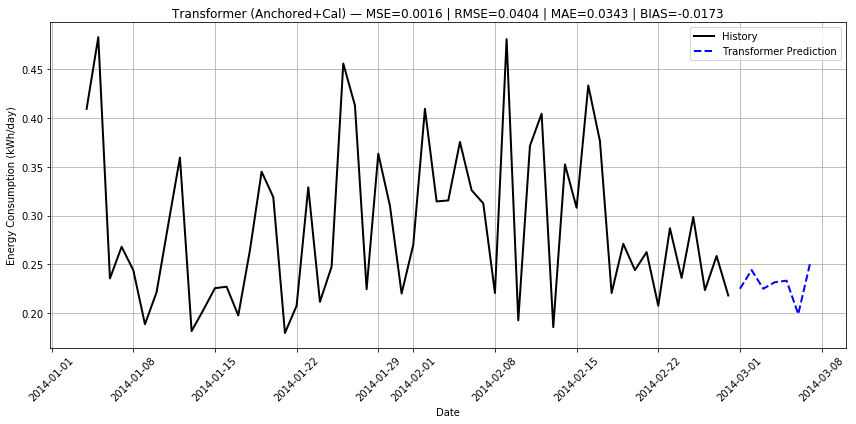

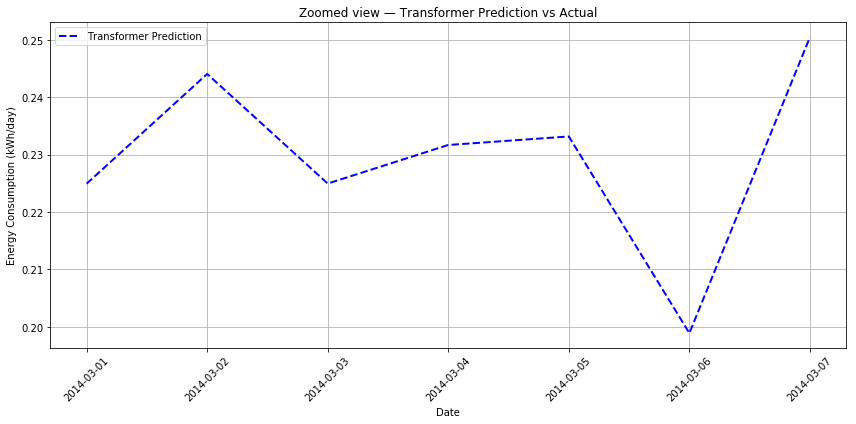

In [225]:
# Cell 13: Forecast last window (anchored + cap) + metrics + plot
def forecast_last_window_anchored(df_one, input_length, horizon, feature_cols, mu, sigma):
    g = df_one.sort_values(DATE_COL).set_index(DATE_COL).resample("D").mean().interpolate().reset_index()
    feats = g[feature_cols].fillna(method="ffill").fillna(method="bfill").fillna(0).values.astype(np.float32)
    tgt   = g[TARGET_COL].values.astype(np.float32)

    if len(g) < input_length + horizon + 1:
        raise ValueError("Chuỗi quá ngắn để forecast.")

    X_hist = torch.from_numpy(feats[-input_length:][None, ...]).to(DEVICE)
    y_last = float(tgt[-1])
    y_last_n = (y_last - mu) / sigma

    model.eval()
    with torch.no_grad():
        delta_raw_n = model(X_hist, y_last_n=None).cpu().numpy().ravel()

    delta_n = DELTA_MAX_N * np.tanh(delta_raw_n)  # thử bỏ tanh để xem kết quả
    pred_n = model.cal_a.item() * (delta_n + y_last_n) + model.cal_b.item()

    y_pred = pred_n * sigma + mu
    y_pred = np.maximum(0.0, y_pred)

    true   = tgt[-horizon:]
    t_hist = g[DATE_COL].values[-input_length:]
    t_fut  = pd.date_range(g[DATE_COL].values[-1] + np.timedelta64(1,'D'), periods=horizon, freq="D")
    return t_hist, tgt[-input_length:], t_fut, true, y_pred

# Sử dụng hàm dự báo
t_hist, y_hist, t_fut, y_true, y_pred = forecast_last_window_anchored(
    feat_df_1, INPUT_LENGTH, HORIZON_STEPS, used_features, mu, sigma
)

# Metrics
err  = y_pred - y_true
mse  = float(np.mean(err**2))
rmse = float(np.sqrt(mse))
mae  = float(np.mean(np.abs(err)))
bias = float(np.mean(err))

# Plot kiểu clean với cách điều chỉnh dự báo
plt.figure(figsize=(12,6))
plt.plot(pd.to_datetime(t_hist), y_hist, label="History", color="black", linewidth=2)
#plt.plot(pd.to_datetime(t_fut),  y_true, label="Actual Future", color="orange", linewidth=2)
plt.plot(pd.to_datetime(t_fut),  y_pred, label="Transformer Prediction", color="blue", linestyle="--", linewidth=2)
plt.xlabel("Date"); plt.ylabel("Energy Consumption (kWh/day)")
plt.title(f"Transformer (Anchored+Cal) — MSE={mse:.4f} | RMSE={rmse:.4f} | MAE={mae:.4f} | BIAS={bias:.4f}")
plt.legend(); plt.xticks(rotation=45); plt.grid(True)
plt.tight_layout()

# Zoomed view for better comparison
plt.figure(figsize=(12,6))
#plt.plot(pd.to_datetime(t_fut),  y_true, label="Actual Future", color="orange", linewidth=2)
plt.plot(pd.to_datetime(t_fut),  y_pred, label="Transformer Prediction", color="blue", linestyle="--", linewidth=2)
plt.xlabel("Date"); plt.ylabel("Energy Consumption (kWh/day)")
plt.title("Zoomed view — Transformer Prediction vs Actual")
plt.legend(); plt.xticks(rotation=45); plt.grid(True)
plt.tight_layout()

plt.show()
